# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import os

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from pandas_profiling import ProfileReport

In [2]:
# import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
def get_data(filename):
    
    """
    Reads the data from the given path.
    """

    pth1 = f'/datasets/{filename}'
    pth2 = f'data/{filename}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
        print(f'Reading {pth1}...')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
        print(f'Reading {pth2}...')
    else:
        print('Check the file path')

    return df

## Подготовка данных

`DateCrawled` — дата скачивания анкеты из базы

`VehicleType` — тип автомобильного кузова

`RegistrationYear` — год регистрации автомобиля

`Gearbox` — тип коробки передач

`Power` — мощность (л. с.)

`Model` — модель автомобиля

`Kilometer` — пробег (км)

`RegistrationMonth` — месяц регистрации автомобиля

`FuelType` — тип топлива

`Brand` — марка автомобиля

`NotRepaired` — была машина в ремонте или нет

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя


In [4]:
file_name = 'autos.csv'

init_df = get_data(file_name)
df = get_data(file_name)

df.head()

Reading data/autos.csv...
Reading data/autos.csv...


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


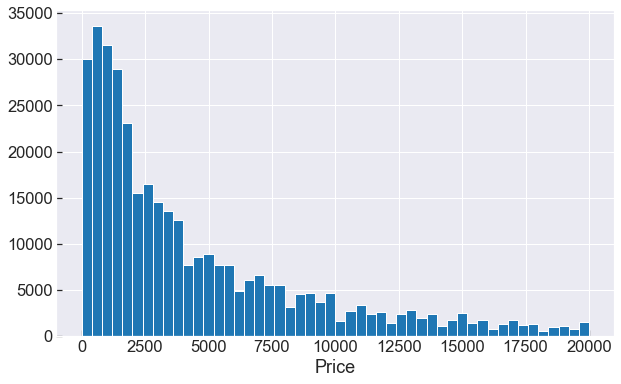

In [5]:
df['Price'].hist(bins=50)

plt.xlabel('Price')

plt.show()

> Довольно много нереалисично малых значений, заменю их на медианное (посчитанное после исключения малых)

In [6]:
# # Машины дешевле этого порога ниже себестоимости материалов, из которых они сделаны
# realistic_price_threshold = 300

# realistic_price_median = df['Price'][df['Price'] > realistic_price_threshold].median()

# df['Price'] = (df['Price']
#                 .where(df['Price'] > realistic_price_threshold, realistic_price_median)
#                 .astype('int'))

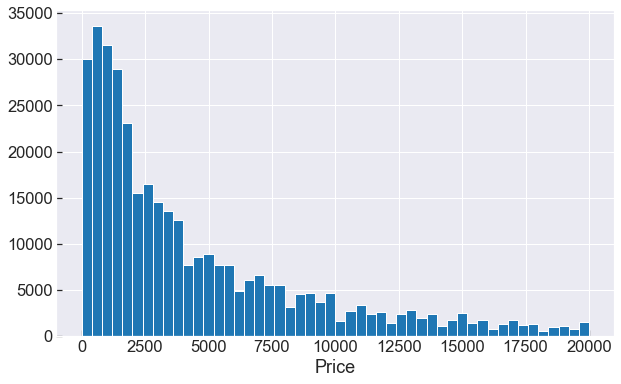

In [7]:
df['Price'].hist(bins=50)

plt.xlabel('Price')

plt.show()

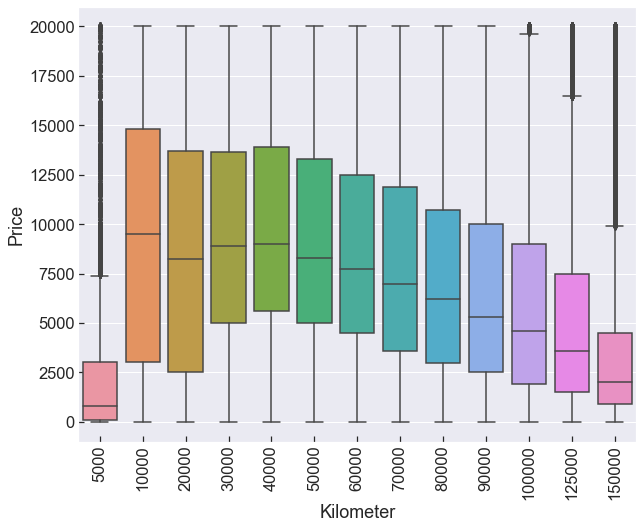

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='Kilometer', y='Price', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

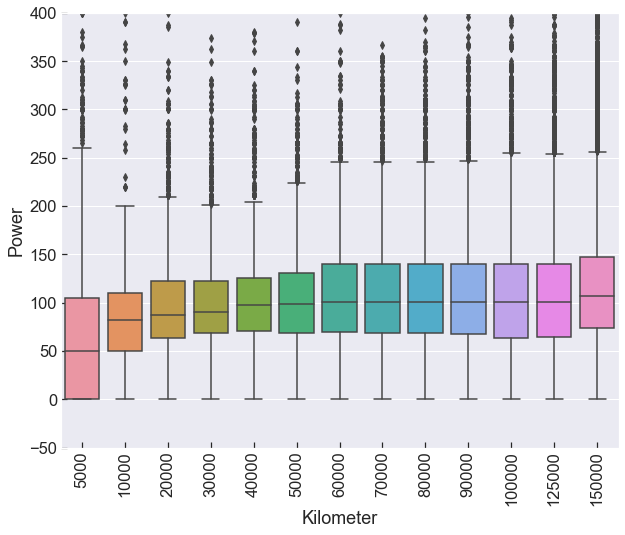

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='Kilometer', y='Power', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# ax.set_yscale('log')
ax.set_ylim(-50, 400)

plt.show()

In [10]:
# profile = ProfileReport(df_5000_km, title="Pandas Profiling Report")

# profile

In [11]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

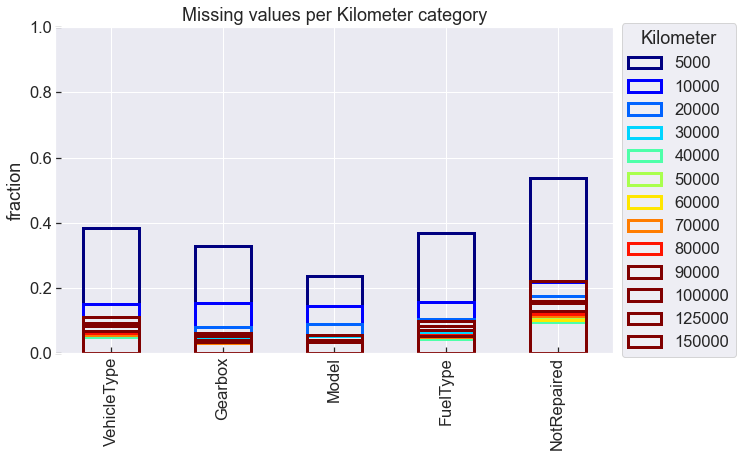

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

km_list = np.sort(df['Kilometer'].unique())

cmap = get_cmap(10, name='jet')
i = 0 # color iterator

for km in km_list:

    km_df = df[df['Kilometer']==km]

    isna_stat_km = km_df.isna().sum() / km_df.shape[0]

    isna_stat_km[isna_stat_km!=0].plot(kind='bar',
                                       color='None',
                                       lw=3,
                                       ax=ax,
                                       edgecolor=cmap(i),
                                       label=f'{km}')
    ax.set_title(f'{km} km')
    ax.set_ylim(0, 1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              title='Kilometer')
    i+=1

ax.set_title('Missing values per Kilometer category')
ax.set_ylabel('fraction')
plt.show()

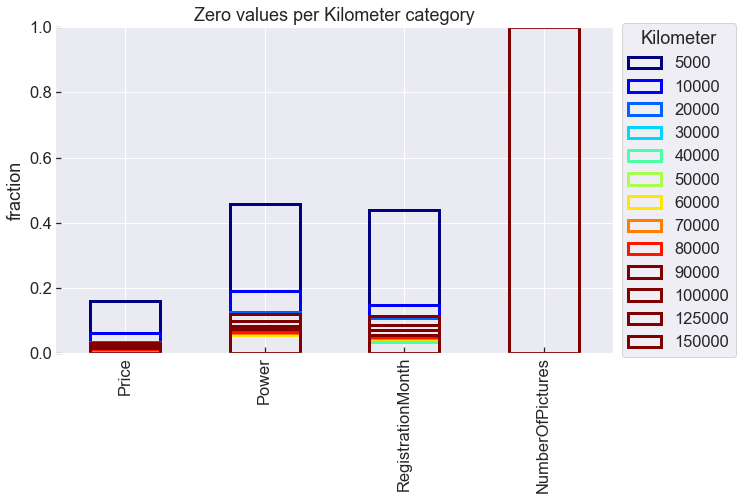

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

km_list = np.sort(df['Kilometer'].unique())

cmap = get_cmap(10, name='jet')
i = 0 # color iterator

median_prices = []

for km in km_list:

    km_df = df[df['Kilometer']==km]

    iszero_stat_km = (km_df == 0).sum() / km_df.shape[0]

    iszero_stat_km[iszero_stat_km!=0].plot(kind='bar',
                                           color='None',
                                           lw=3,
                                           ax=ax,
                                           edgecolor=cmap(i),
                                           label=f'{km}')
    ax.set_title(f'{km} km')
    ax.set_ylim(0, 1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              title='Kilometer')
    i+=1

ax.set_title('Zero values per Kilometer category')
ax.set_ylabel('fraction')

plt.show()

<div class="alert alert-block alert-warning">
<b> Комментарий студента</b>
    
Существенная доля данных для машин с пробегом 5000 км пропущена (в колонках VehicleType, Gearbox, Model, FuelType, NotRepaired) или равна нулю (в колонках Price, Power, RegistrationMonth, NumberOfPictures). Распределение цены для этих машин выпадает из общего тренда (меньше пробег - дороже машина). Попробую удалить эту категорию из датасета, а все пропуски в цене заменить на медианное значение по всему датафрейму.

</div>

In [14]:
df = df[df['Kilometer']!=5000]

df['Price'] = df['Price'].replace(0, df['Price'].median())

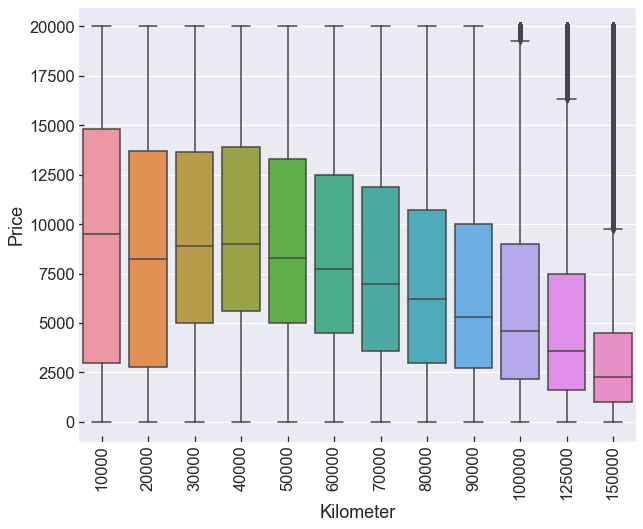

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='Kilometer', y='Price', ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

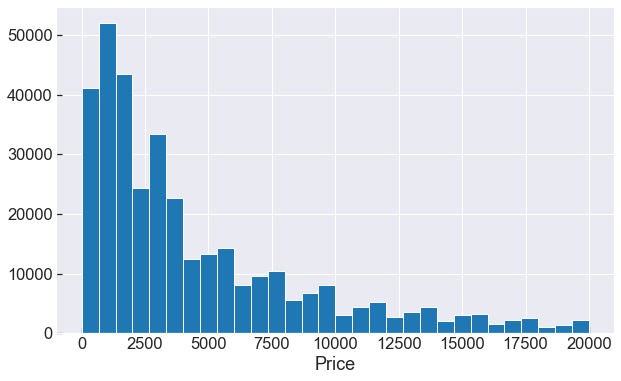

In [15]:
df['Price'].hist(bins=30)

plt.xlabel('Price')

plt.show()

In [16]:
# profile = ProfileReport(init_df, title="Pandas Profiling Report")

# profile

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347972 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        347972 non-null  object
 1   Price              347972 non-null  int64 
 2   VehicleType        312930 non-null  object
 3   RegistrationYear   347972 non-null  int64 
 4   Gearbox            330243 non-null  object
 5   Power              347972 non-null  int64 
 6   Model              329777 non-null  object
 7   Kilometer          347972 non-null  int64 
 8   RegistrationMonth  347972 non-null  int64 
 9   FuelType           317445 non-null  object
 10  Brand              347972 non-null  object
 11  NotRepaired        280249 non-null  object
 12  DateCreated        347972 non-null  object
 13  NumberOfPictures   347972 non-null  int64 
 14  PostalCode         347972 non-null  int64 
 15  LastSeen           347972 non-null  object
dtypes: int64(7), object(

In [18]:
# profile = ProfileReport(df, title="Pandas Profiling Report")

# profile

### Предобработка и заполнение пропусков

In [19]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [20]:
# Допускаю, что цена на авто может зависеть от даты создания объявления: ситуация на рынке 
# вторичных автомобилей изменчива
creation_date = pd.to_datetime(df['DateCreated'])

df['CreationYear'] = creation_date.dt.year
df['CreationMonth'] = creation_date.dt.month
df['CreationDay'] = creation_date.dt.day

# А вот даты 'DateCrawled' и 'LastSeen', а также почтовый код не вижу смысла оставлять среди признаков.
# Колонка 'NumberOfPictures' заполнена нулями, ее ждет та же судьба
df = df.drop(columns=['DateCreated', 'DateCrawled', 'LastSeen',
                      'PostalCode', 'NumberOfPictures'])

df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'CreationYear', 'CreationMonth', 'CreationDay'],
      dtype='object')

In [21]:
# 'gasoline' и 'petrol' обозначают одно и то же -- бензин
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

df['FuelType'].value_counts(normalize=True)

petrol      0.980198
lpg         0.016570
cng         0.001748
hybrid      0.000725
other       0.000504
electric    0.000255
Name: FuelType, dtype: float64

In [22]:
df.isna().sum()[df.isna().sum()!=0]

VehicleType    35042
Gearbox        17729
Model          18195
FuelType       30527
NotRepaired    67723
dtype: int64

In [23]:
# Случайный автомобиль с вероятностью 75% будет с ручной коробкой передач
df['Gearbox'] = df['Gearbox'].fillna('manual')
# Случайный автомобиль с вероятностью 98% будет работать на бензине
df['FuelType'] = df['FuelType'].fillna('petrol')
# Случайный автомобиль с вероятностью 70% побывал в ремонте
df['NotRepaired'] = df['NotRepaired'].fillna('no')

<!-- `VehicleType` придется заменить, а вот `Model` просто уберу из признаков: слишком много различных значений для формулирования адекватного способа заполнения пропусков. -->

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347972 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              347972 non-null  int64 
 1   VehicleType        312930 non-null  object
 2   RegistrationYear   347972 non-null  int64 
 3   Gearbox            347972 non-null  object
 4   Power              347972 non-null  int64 
 5   Model              329777 non-null  object
 6   Kilometer          347972 non-null  int64 
 7   RegistrationMonth  347972 non-null  int64 
 8   FuelType           347972 non-null  object
 9   Brand              347972 non-null  object
 10  NotRepaired        347972 non-null  object
 11  CreationYear       347972 non-null  int64 
 12  CreationMonth      347972 non-null  int64 
 13  CreationDay        347972 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 39.8+ MB


In [25]:
# Изменю тип данных 'object' на 'category' для совместимости с lightGBM
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347972 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              347972 non-null  int64   
 1   VehicleType        312930 non-null  category
 2   RegistrationYear   347972 non-null  int64   
 3   Gearbox            347972 non-null  category
 4   Power              347972 non-null  int64   
 5   Model              329777 non-null  category
 6   Kilometer          347972 non-null  int64   
 7   RegistrationMonth  347972 non-null  int64   
 8   FuelType           347972 non-null  category
 9   Brand              347972 non-null  category
 10  NotRepaired        347972 non-null  category
 11  CreationYear       347972 non-null  int64   
 12  CreationMonth      347972 non-null  int64   
 13  CreationDay        347972 non-null  int64   
dtypes: category(6), int64(8)
memory usage: 26.2 MB


## Обучение моделей

### LightGBM

In [26]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catetory_columns = list(X.select_dtypes(include=['category']).columns)

catetory_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [27]:
lgbm_model = LGBMRegressor(random_state=42, metric='rmse')

In [28]:
%%time
lgbm_model.fit(X_train, y_train, categorical_feature=catetory_columns)

/Users/mike/opt/anaconda3/envs/practicum_new/lib/python3.10/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: user 4.67 s, sys: 652 ms, total: 5.32 s
Wall time: 930 ms


LGBMRegressor(metric='rmse', random_state=42)

In [29]:
lgbm_predictions = lgbm_model.predict(X_test)

lgbm_rmse = mse(y_test, lgbm_predictions) ** 0.5

print(f'LightGBM RMSE: {lgbm_rmse:.0f}')

LightGBM RMSE: 1717


In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
param_grid = {
    'num_leaves': np.arange(500, 1200, 20),
    'min_data_in_leaf': [30, 40, 50, 80]
    }

In [32]:
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=50,
    random_state=42
)

In [33]:
%%time
random_search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START min_data_in_leaf=80, num_leaves=560........................
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 1/3; 1/10] END min_data_in_leaf=80, num_leaves=560;, score=-1643.660 total time=   5.0s
[CV 2/3; 1/10] START min_data_in_leaf=80, num_leaves=560........................
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 2/3; 1/10] END min_data_in_leaf=80, num_leaves=560;, score=-1657.528 total time=   5.1s
[CV 3/3; 1/10] START min_data_in_leaf=80, num_leaves=560........................
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[CV 3/3; 1/10] END min_data_in_leaf=80, num_leaves=560;, score=-1645.512 total time=   4.7s
[CV 1/3; 2/10] START min_data_in_leaf=40, num_leaves=1

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='rmse', random_state=42),
                   param_distributions={'min_data_in_leaf': [30, 40, 50, 80],
                                        'num_leaves': array([ 500,  520,  540,  560,  580,  600,  620,  640,  660,  680,  700,
        720,  740,  760,  780,  800,  820,  840,  860,  880,  900,  920,
        940,  960,  980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140,
       1160, 1180])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=50)

In [34]:
-random_search_lgbm.best_score_

1643.7972784114818

In [35]:
random_search_lgbm.best_params_

{'num_leaves': 1140, 'min_data_in_leaf': 40}

In [36]:
random_lgbm_predictions = random_search_lgbm.predict(X_test)

lgbm_rmse = mse(y_test, random_lgbm_predictions) ** 0.5

print(f'LightGBM RMSE: {lgbm_rmse:.2f}')

LightGBM RMSE: 1606.63


### Тесты на сторонних данных

In [37]:
honda_test_df = pd.Series(
          {'VehicleType': 'small',
          'RegistrationYear': 2006,
          'Gearbox': 'manual',
          'Power': 83,
          'Model': 'fit',
          'Kilometer': 95000,
          'RegistrationMonth': 1,
          'FuelType': 'petrol',
          'Brand': 'honda',
          'NotRepaired': 'no',
          'CreationYear': 2016,
          'CreationMonth': 6,
          'CreationDay': 6})

honda_test_df = pd.DataFrame(honda_test_df).T

honda_test_df

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CreationYear,CreationMonth,CreationDay
0,small,2006,manual,83,fit,95000,1,petrol,honda,no,2016,6,6


In [38]:
honda_test_less_km_df = pd.Series(
          {'VehicleType': 'small',
          'RegistrationYear': 2006,
          'Gearbox': 'manual',
          'Power': 83,
          'Model': 'fit',
          'Kilometer': 5000,
          'RegistrationMonth': 1,
          'FuelType': 'petrol',
          'Brand': 'honda',
          'NotRepaired': 'no',
          'CreationYear': 2016,
          'CreationMonth': 6,
          'CreationDay': 6})

honda_test_less_km_df = pd.DataFrame(honda_test_less_km_df).T

honda_test_less_km_df

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CreationYear,CreationMonth,CreationDay
0,small,2006,manual,83,fit,5000,1,petrol,honda,no,2016,6,6


In [39]:
volvo_test_df = pd.Series(
          {'VehicleType': 'crossover',
          'RegistrationYear': 2016,
          'Gearbox': 'auto',
          'Power': 190,
          'Model': 'XC60',
          'Kilometer': 135000,
          'RegistrationMonth': 1,
          'FuelType': 'disel',
          'Brand': 'volvo',
          'NotRepaired': 'no',
          'CreationYear': 2016,
          'CreationMonth': 6,
          'CreationDay': 6})

volvo_test_df = pd.DataFrame(volvo_test_df).T

volvo_test_df

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CreationYear,CreationMonth,CreationDay
0,crossover,2016,auto,190,XC60,135000,1,disel,volvo,no,2016,6,6


In [73]:
volvo_test_less_km_df = pd.Series(
          {'VehicleType': 'crossover',
          'RegistrationYear': 2016,
          'Gearbox': 'auto',
          'Power': 190,
          'Model': 'XC60',
          'Kilometer': 35000,
          'RegistrationMonth': 1,
          'FuelType': 'disel',
          'Brand': 'volvo',
          'NotRepaired': 'no',
          'CreationYear': 2016,
          'CreationMonth': 6,
          'CreationDay': 6})

volvo_test_less_km_df = pd.DataFrame(volvo_test_less_km_df).T

volvo_test_less_km_df

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CreationYear,CreationMonth,CreationDay
0,crossover,2016,auto,190,XC60,35000,1,disel,volvo,no,2016,6,6


In [74]:
def prepare_test(sila_df):

    for column in catetory_columns:
        sila_df[column] = sila_df[column].astype('category')

    # Изменю тип данных 'object' на 'category' для совместимости с lightGBM
    for column in sila_df.select_dtypes(include=['object']).columns:
        sila_df[column] = sila_df[column].astype('int64')

    return sila_df

In [75]:
volvo_test_less_km_df

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,CreationYear,CreationMonth,CreationDay
0,crossover,2016,auto,190,XC60,35000,1,disel,volvo,no,2016,6,6


In [76]:
volvo_test_df = prepare_test(volvo_test_df)
volvo_test_less_km_df = prepare_test(volvo_test_less_km_df)
honda_test_df = prepare_test(honda_test_df)
honda_test_less_km_df = prepare_test(honda_test_less_km_df)

__При уменьшении пробега цена падает:__

🤔

In [77]:
random_search_lgbm.predict(volvo_test_df)[0], random_search_lgbm.predict(volvo_test_less_km_df)[0]

(8907.188136667288, 6610.8291791026295)

In [78]:
random_search_lgbm.predict(honda_test_df)[0], random_search_lgbm.predict(honda_test_less_km_df)[0]

(4019.5719320606045, 4837.686358956837)

<div class="alert alert-block alert-warning">
<b> Комментарий студента</b>
    
Это может быть показателем того, что модель обучена неверно?

Или, например, проблемы с данными?

</div>

### Linear regression

In [46]:
# Encoding
X_train_ohe = X_train.drop(columns=['Brand', 'Model'])
X_train_ohe = pd.get_dummies(X_train_ohe)

X_test_ohe = X_test.drop(columns=['Brand', 'Model'])
X_test_ohe = pd.get_dummies(X_test_ohe)

In [47]:
numerical_columns = list(X_train_ohe.select_dtypes(include=['int64']).columns)

numerical_columns

['RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'CreationYear',
 'CreationMonth',
 'CreationDay']

In [48]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_train_ohe[numerical_columns])

X_train_ohe[numerical_columns] = scaler.transform(X_train_ohe[numerical_columns])
X_test_ohe[numerical_columns] = scaler.transform(X_test_ohe[numerical_columns])

In [49]:
linear_model = LinearRegression()

In [50]:
%time
linear_model.fit(X_train_ohe, y_train)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


LinearRegression()

In [51]:

linear_predictions = linear_model.predict(X_test_ohe)
linear_rmse = mse(y_test, linear_predictions) ** 0.5

print(f'Linear RMSE: {linear_rmse:.0f}')

Linear RMSE: 3562


## Анализ моделей

Простая линейная модель обучается очень быстро (микросекунды), но в ее предсказаниях присутствуют большие ошибки (метрика RMSE составляет 3687. Подбор гиперпараметров и обучение модели градиентного бустинга LightGBM занимает гораздо больше времени (около 3 минут), но при этом ошибка RMSE сокращается более чем на 50% (до 1644).

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей